
**Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

**Edición 2021**

---
## Trabajo práctico entregable - Parte 1 A

In [ ]:
import io
import matplotlib
import matplotlib.pyplot as plt
import numpy
import pandas as pd
import seaborn
import scipy.stats as stats

seaborn.set_context('talk')

In [ ]:
url = 'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/sysarmy_survey_2020_processed.csv'
df = pd.read_csv(url)

# Ejercicio 1 - Análisis descriptivo

**¿Cuáles son los lenguajes de programación asociados a los mejores salarios?**

### Selección de columnas relevantes a utilizar

In [ ]:
# Columnas relevantes a analizar
relevant_columns = ['tools_programming_languages', 'salary_monthly_NETO', 'profile_years_experience']
df[relevant_columns]
df_copy = df[relevant_columns].copy()

In [ ]:
# Convert the comma-separated string of languages to a list of string.
# Remove 'ninguno de los anteriores' option, spaces and training commas.
def split_languages(languages_str):
  if not isinstance(languages_str, str):
    return []
  # Remove 'other' option
  languages_str = languages_str.lower()\
    .replace('ninguno de los anteriores', '')
  # Split string into list of items
  # Remove spaces and commas for each item
  return [lang.strip().replace(',', '')
          for lang in languages_str.split()]

# Create a new column with the list of languages
df.loc[:, 'cured_programming_languages'] = df.tools_programming_languages\
    .apply(split_languages)
if 'cured_programming_languages' not in relevant_columns:
    relevant_columns.append('cured_programming_languages') 

# Duplicate each row of df for each programming language
# mentioned in the response.
# We only include in df_lang the columns we are going to analyze later, so we
# don't duplicate innecesary information.
df_lang = df.cured_programming_languages\
    .apply(pd.Series).stack()\
    .reset_index(level=-1, drop=True).to_frame()\
    .join(df[relevant_columns])\
    .rename(columns={0: 'programming_language'})
# Horrible programming style! But a lot of data science code can be written with
# as concatenations of functions (pipelines), and there's no elegant way of
# doing that on Python.
df_lang[:10]

,programming_language,tools_programming_languages,salary_monthly_NETO,profile_years_experience,cured_programming_languages
0,ninguno,Ninguno,43000.0,3.0,[ninguno]
1,html,"HTML, Javascript, Python",63000.0,5.0,"[html, javascript, python]"
1,javascript,"HTML, Javascript, Python",63000.0,5.0,"[html, javascript, python]"
1,python,"HTML, Javascript, Python",63000.0,5.0,"[html, javascript, python]"
2,ninguno,Ninguno,127000.0,2.0,[ninguno]
3,bash/shell,"Bash/Shell, C, CSS, HTML, Java, Javascript, PH...",102000.0,15.0,"[bash/shell, c, css, html, java, javascript, p..."
3,c,"Bash/Shell, C, CSS, HTML, Java, Javascript, PH...",102000.0,15.0,"[bash/shell, c, css, html, java, javascript, p..."
3,css,"Bash/Shell, C, CSS, HTML, Java, Javascript, PH...",102000.0,15.0,"[bash/shell, c, css, html, java, javascript, p..."
3,html,"Bash/Shell, C, CSS, HTML, Java, Javascript, PH...",102000.0,15.0,"[bash/shell, c, css, html, java, javascript, p..."
3,java,"Bash/Shell, C, CSS, HTML, Java, Javascript, PH...",102000.0,15.0,"[bash/shell, c, css, html, java, javascript, p..."


Eliminamos los outliers, solo utilizamos aquellos valores que están por arriba del 25% y por debajo del 75%.

In [ ]:
def remove_outlier(df_in, col_name, iqr_factor):
    """
  IQR outliers removal (https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/)
  accept a dataframe, remove outliers, return cleaned data in a new dataframe
  see http://www.itl.nist.gov/div898/handbook/prc/section1/prc16.htm
  """
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3 - q1  # interquartile range
    fence_low = q1 - iqr_factor * iqr
    fence_high = q3 + iqr_factor * iqr
    df_inliers = df_in.loc[
        (df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)
    ]
    df_outliers = df_in.loc[
        (df_in[col_name] < fence_low) | (df_in[col_name] > fence_high)
    ]
    return df_inliers, df_outliers

In [ ]:
iqr_factor = 2.5
df_main_inliers, df_main_outliers = remove_outlier(df_lang, "salary_monthly_NETO", iqr_factor)
display(len(df_main_inliers) / len(df_lang))

0.9155

También filtramos los datos que están por debajo del salario mínimo vital y móvil

In [ ]:
df_main_inliers = df_main_inliers[df_main_inliers["salary_monthly_NETO"] > 24000]
df_inliers = df_main_inliers.copy()
# Filtramos por el mínimo vital y móvil

Analizamos la frecuencia de cada lenguaje

In [ ]:
language_count = df_lang.programming_language.value_counts()\
    .reset_index()\
    .rename(columns={'index': 'language', 'programming_language': 'frequency'})
language_count[:10]

,language,frequency
0,javascript,2513
1,sql,2154
2,html,1861
3,python,1475
4,java,1453
5,css,1247
6,bash/shell,993
7,php,891
8,.net,823
9,typescript,779


Seleccionamos los lenguajes con frecuencia mayor a 735

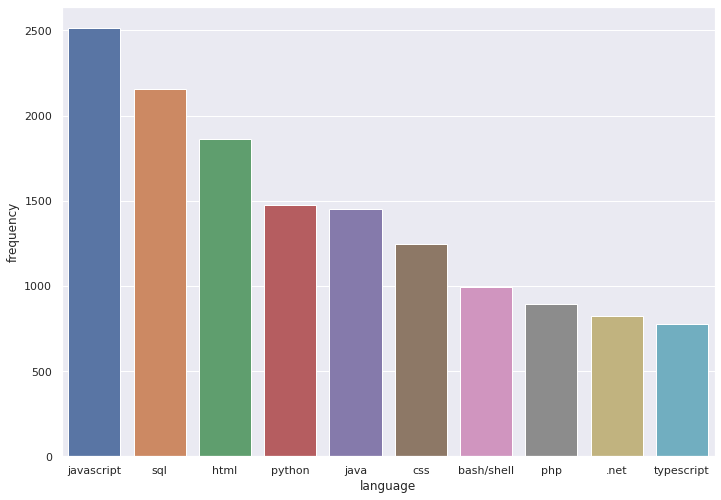

In [ ]:
language_count=language_count[language_count['frequency']>735]
seaborn.set(rc={'figure.figsize':(11.7,8.27)})
seaborn.barplot(data=language_count, x='language', y='frequency')
#elijo solo los primeros 10 para una correcta visualizacion

Elegimos los 10 lengujaes mas utilizados por las personas que realizaron la encuensta.

In [ ]:
seaborn.set(rc={'figure.figsize':(11.7,8.27)})
relevant_programming_lang = ['javascript', 'sql', 'html', 'java', 'python', 'css', 'bash/shell', 'php', '.net', 'typescript']
df_relevant_programming_lang =  df_main_inliers[df_main_inliers.programming_language.isin(relevant_programming_lang)]
df_relevant_programming_lang.describe()

,salary_monthly_NETO,profile_years_experience
count,12325.000000,12325.000000
mean,86100.531766,8.509533
std,40288.118508,6.953734
min,24500.000000,0.000000
25%,56000.000000,3.000000
50%,80000.000000,7.000000
75%,105000.000000,12.000000
max,248000.000000,115.000000


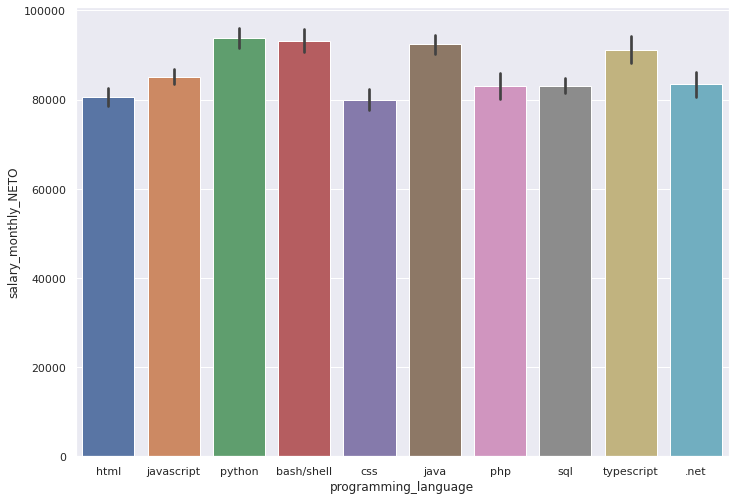

In [ ]:
seaborn.barplot(data=df_relevant_programming_lang, x='programming_language', y='salary_monthly_NETO')

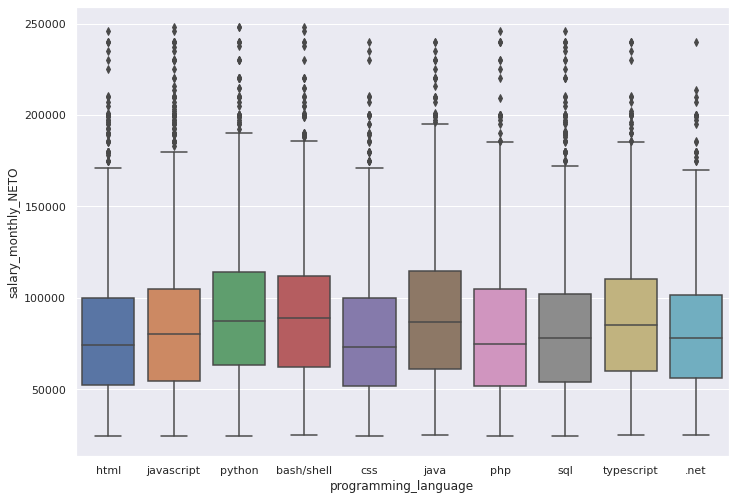

In [ ]:
seaborn.boxplot(data=df_relevant_programming_lang, x='programming_language', y='salary_monthly_NETO')

Creamos nuevas columnas según el lenguaje para poder realizar un histograma con cada uno

In [ ]:
relevant_programming_lang = ['javascript', 'sql', 'html', 'java', 'python', 'css', 'bash/shell', 'php', '.net', 'typescript']
for i in relevant_programming_lang:    
  if i == 'bash/shell' :
    df_relevant_programming_lang['bash_shell'] = numpy.where(df_relevant_programming_lang['programming_language']== i,1,0)
  elif i == '.net' :
    df_relevant_programming_lang['dot_net'] = numpy.where(df_relevant_programming_lang['programming_language']== i,1,0)
  else:
    df_relevant_programming_lang[i] = numpy.where(df_relevant_programming_lang['programming_language']== i,1,0)
df_relevant_programming_lang.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

,programming_language,tools_programming_languages,salary_monthly_NETO,profile_years_experience,cured_programming_languages,javascript,sql,html,java,python,css,bash_shell,php,dot_net,typescript
1,html,"HTML, Javascript, Python",63000.0,5.0,"[html, javascript, python]",0,0,1,0,0,0,0,0,0,0
1,javascript,"HTML, Javascript, Python",63000.0,5.0,"[html, javascript, python]",1,0,0,0,0,0,0,0,0,0
1,python,"HTML, Javascript, Python",63000.0,5.0,"[html, javascript, python]",0,0,0,0,1,0,0,0,0,0
3,bash/shell,"Bash/Shell, C, CSS, HTML, Java, Javascript, PH...",102000.0,15.0,"[bash/shell, c, css, html, java, javascript, p...",0,0,0,0,0,0,1,0,0,0
3,css,"Bash/Shell, C, CSS, HTML, Java, Javascript, PH...",102000.0,15.0,"[bash/shell, c, css, html, java, javascript, p...",0,0,0,0,0,1,0,0,0,0


In [ ]:
def histogram_hip(dataframe,var_a,var_b):
        ttestt = stats.ttest_ind(dataframe.query(f'{var_a} == 1')[var_b],dataframe.query(f'{var_a} == 0')[var_b])
        hist1 = dataframe.query(f'{var_a} == 1')[var_b].dropna()
        hist2 = dataframe.query(f'{var_a} == 0')[var_b].dropna() 
        mean1 = hist1.mean()
        mean2=hist2.mean()
        plt.subplot(1, 2, 1)
        plt.hist(hist1, alpha=.8, color='lightgrey')
        plt.axvline(mean1,color='red', label="Media: sueldo neto")
        plt.title(f"Hist. lenguaje:{var_a}".format(var_b, round(mean1, 3))),plt.legend()
        plt.subplot(1, 2, 2)
        plt.hist(hist2, alpha=.8, color='lightgrey')
        plt.axvline(mean2,color='red', label="Media: sueldo neto")
        plt.title("Hist. del resto de los lenguajes".format(var_b, round(mean2, 3))),plt.legend()
        plt.rcParams["figure.figsize"] = (15, 10)
        print (ttestt)
        print()
        print(f"Media del lenguaje: {var_a}",mean1 )
        print()
        print('Media del resto de los otros lenguajes:',mean2)
        print()
        print('Diferencia entre este lenguaje y los otros:',mean1-mean2)
        print()

Ttest_indResult(statistic=-1.2207842193636014, pvalue=0.22219108793897693)

Media del lenguaje: javascript 85136.7875860465

Media del resto de los otros lenguajes: 86304.1730427518

Diferencia entre este lenguaje y los otros: -1167.3854567053058



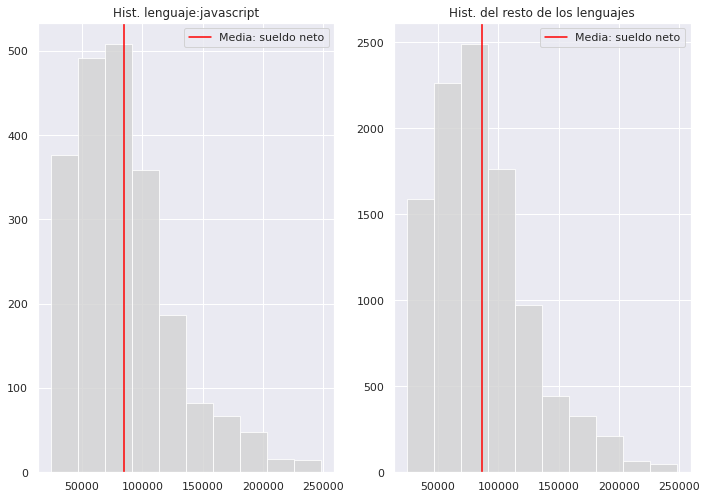

In [ ]:
histogram_hip(df_relevant_programming_lang,'javascript','salary_monthly_NETO')

Ttest_indResult(statistic=7.202102805820429, pvalue=6.273818142633693e-13)

Media del lenguaje: python 93772.28702427563

Media del resto de los otros lenguajes: 85213.78018555391

Diferencia entre este lenguaje y los otros: 8558.506838721718



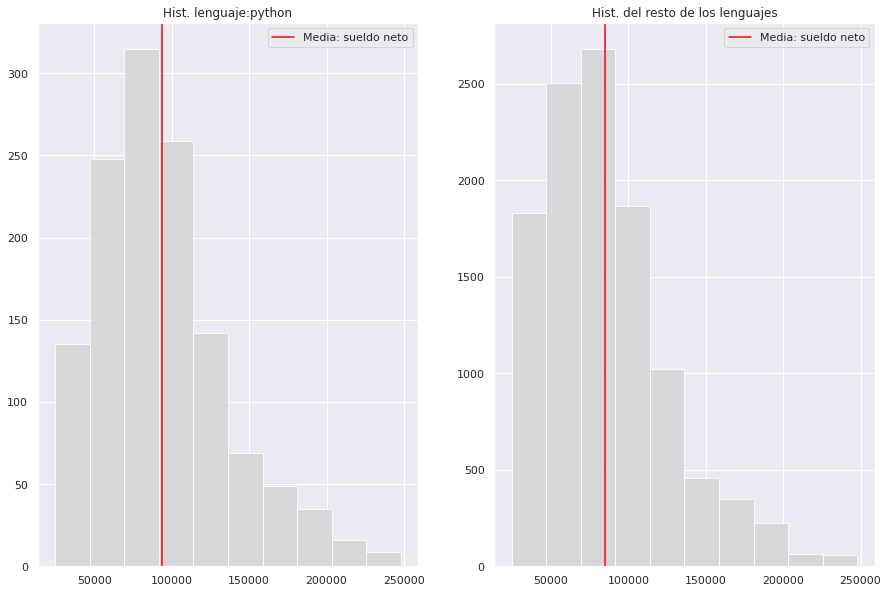

In [ ]:
histogram_hip(df_relevant_programming_lang,'python','salary_monthly_NETO')

Ttest_indResult(statistic=-3.5663005711719977, pvalue=0.0003634283473010272)

Media del lenguaje: sql 83073.26129269575

Media del resto de los otros lenguajes: 86653.29473997309

Diferencia entre este lenguaje y los otros: -3580.0334472773393



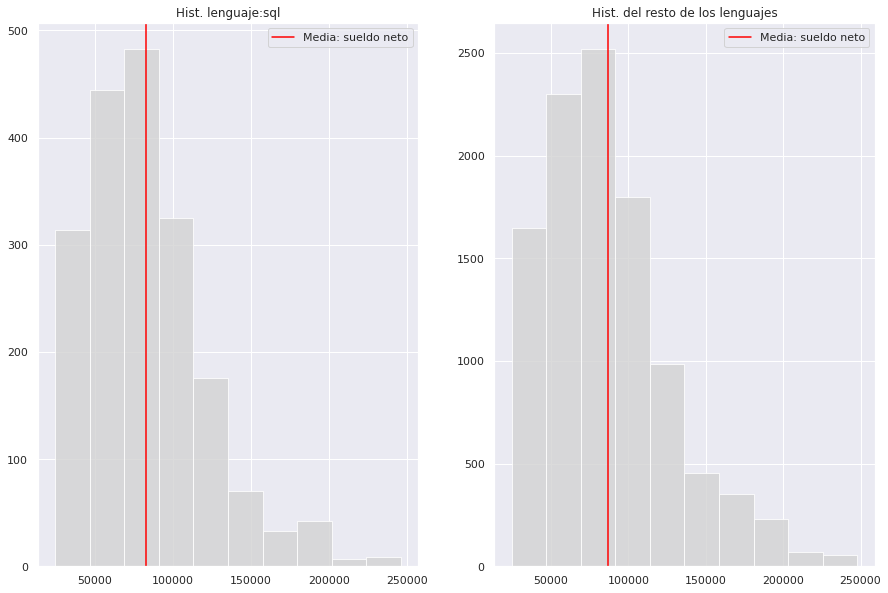

In [ ]:
histogram_hip(df_relevant_programming_lang,'sql','salary_monthly_NETO')

Ttest_indResult(statistic=-5.819587483897606, pvalue=6.046124718782334e-09)

Media del lenguaje: html 80643.90475655432

Media del resto de los otros lenguajes: 86915.7435978737

Diferencia entre este lenguaje y los otros: -6271.83884131939



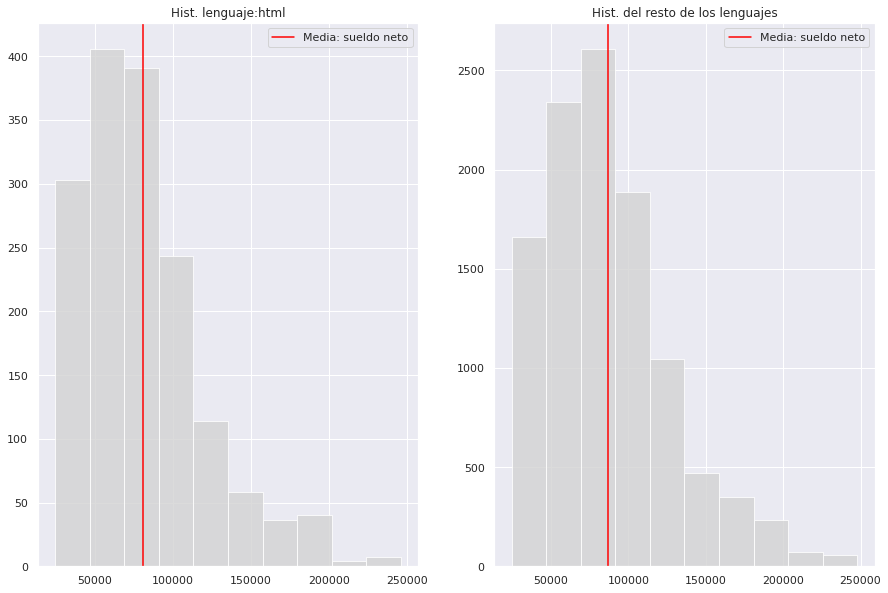

In [ ]:
histogram_hip(df_relevant_programming_lang,'html','salary_monthly_NETO')

Ttest_indResult(statistic=5.915182268120818, pvalue=3.403055354317665e-09)

Media del lenguaje: java 92370.20494573643

Media del resto de los otros lenguajes: 85367.60214227455

Diferencia entre este lenguaje y los otros: 7002.602803461879



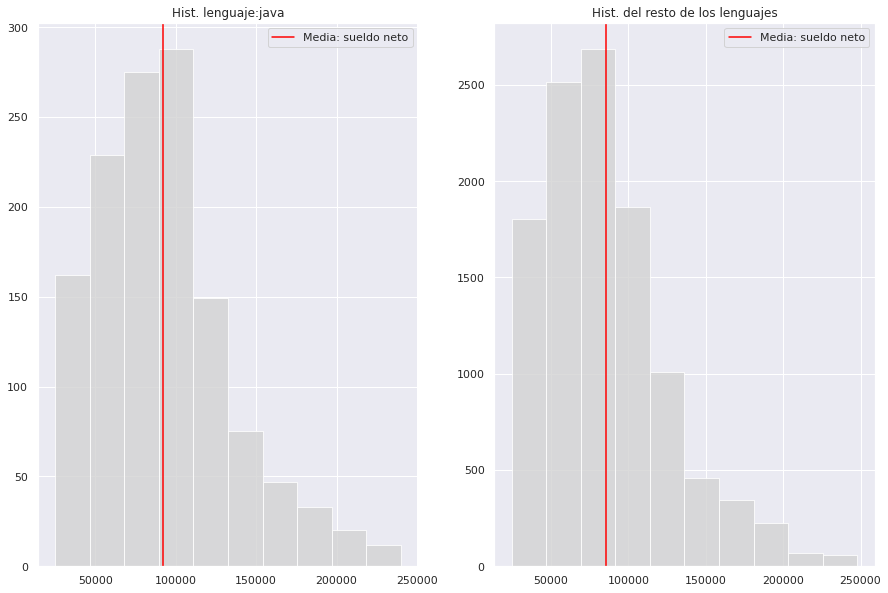

In [ ]:
histogram_hip(df_relevant_programming_lang,'java','salary_monthly_NETO')

Ttest_indResult(statistic=-5.256105415194245, pvalue=1.4959557930994436e-07)

Media del lenguaje: css 79920.93983177569

Media del resto de los otros lenguajes: 86688.01851621499

Diferencia entre este lenguaje y los otros: -6767.078684439301



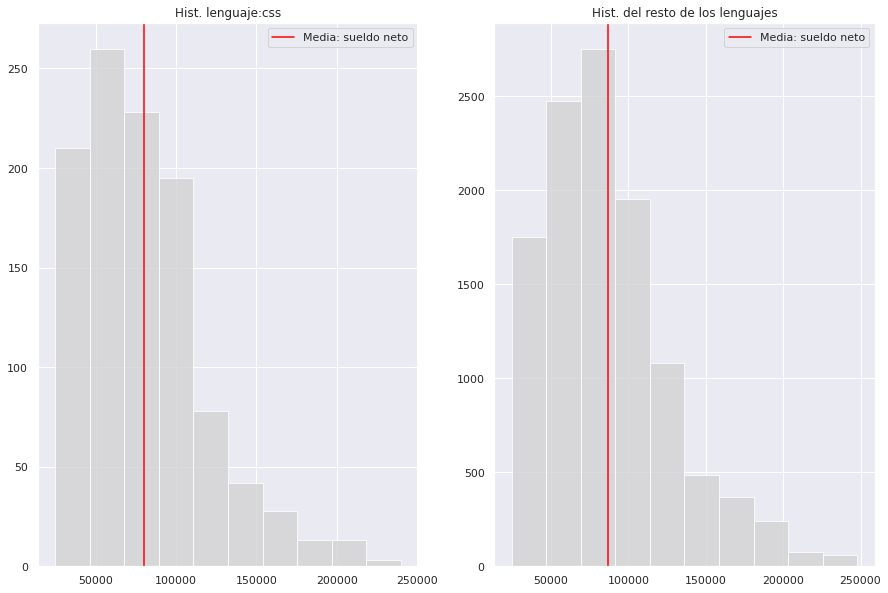

In [ ]:
histogram_hip(df_relevant_programming_lang,'css','salary_monthly_NETO')

Ttest_indResult(statistic=5.426413635047215, pvalue=5.858528147545908e-08)

Media del lenguaje: bash_shell 93163.85395715895

Media del resto de los otros lenguajes: 85552.78156670745

Diferencia entre este lenguaje y los otros: 7611.072390451503



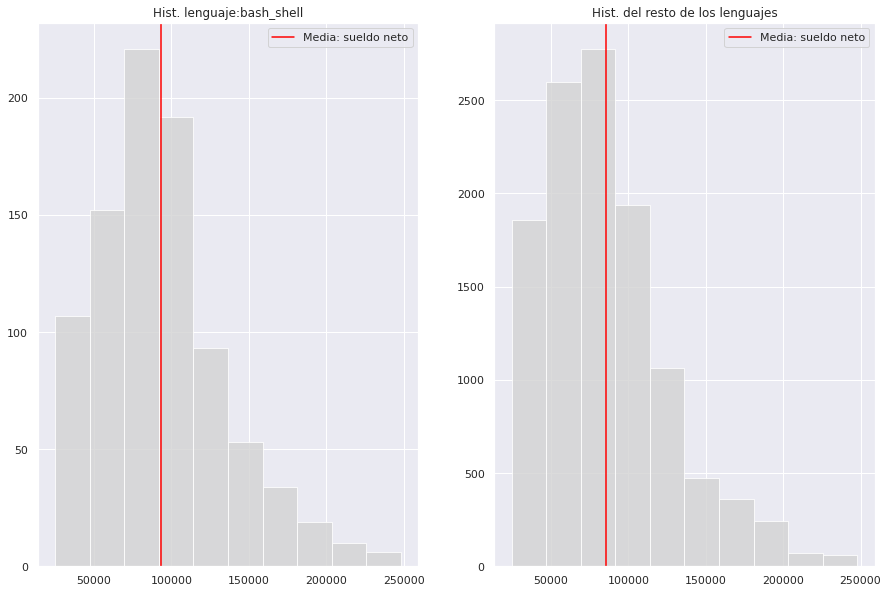

In [ ]:
histogram_hip(df_relevant_programming_lang,'bash_shell','salary_monthly_NETO')

Ttest_indResult(statistic=-2.2018120255658795, pvalue=0.027697050579713743)

Media del lenguaje: php 83003.56483745124

Media del resto de los otros lenguajes: 86306.62103322947

Diferencia entre este lenguaje y los otros: -3303.056195778234



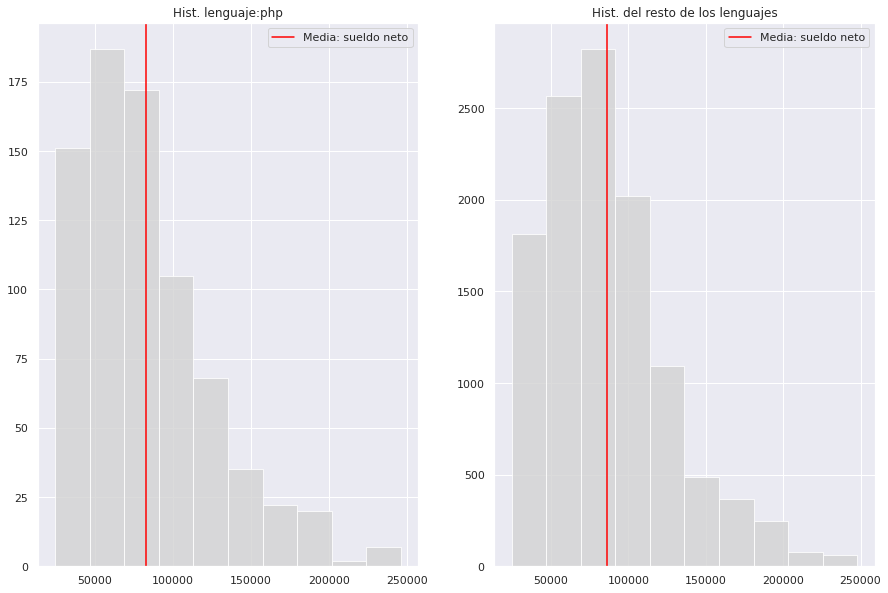

In [ ]:
histogram_hip(df_relevant_programming_lang,'php','salary_monthly_NETO')

Ttest_indResult(statistic=-1.8408350456238496, pvalue=0.06566976109733408)

Media del lenguaje: dot_net 83412.8649232915

Media del resto de los otros lenguajes: 86266.54289024808

Diferencia entre este lenguaje y los otros: -2853.677966956573



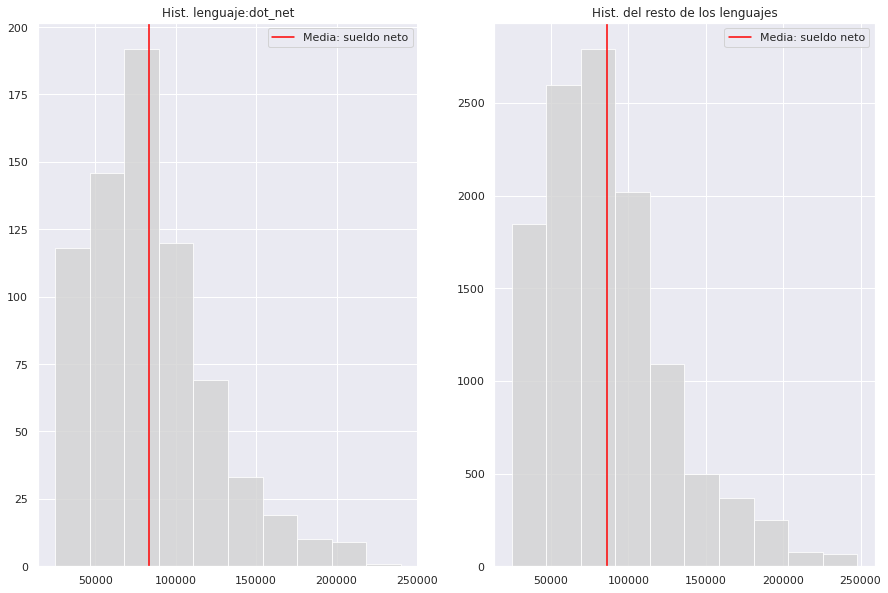

In [ ]:
histogram_hip(df_relevant_programming_lang,'dot_net','salary_monthly_NETO')

Ttest_indResult(statistic=3.323714548573033, pvalue=0.0008908601192822308)

Media del lenguaje: typescript 91169.27962121213

Media del resto de los otros lenguajes: 85813.74448949847

Diferencia entre este lenguaje y los otros: 5355.5351317136665



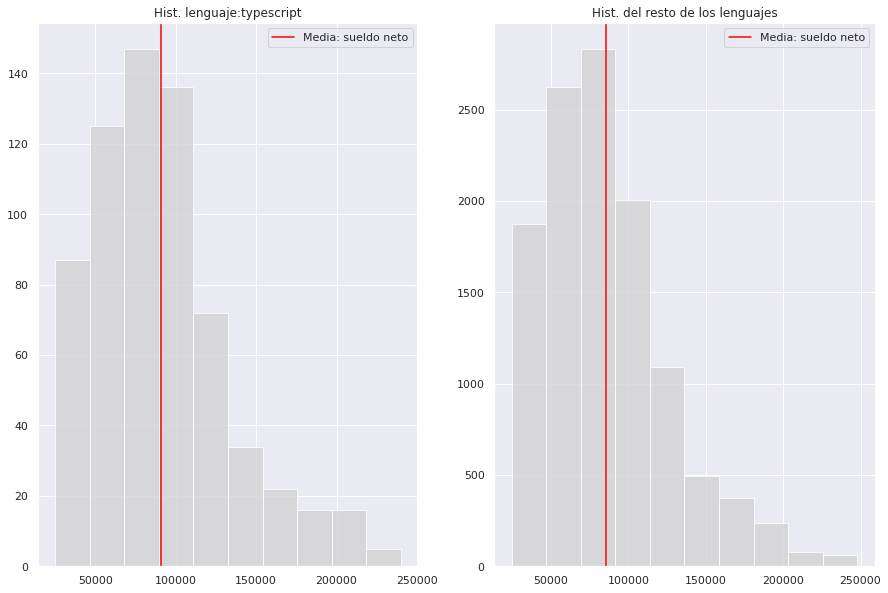

In [ ]:
histogram_hip(df_relevant_programming_lang,'typescript','salary_monthly_NETO')

### Otra forma de visualización 

seniority                         Junior    Semi-Senior         Senior
tools_programming_language                                            
.NET                        55295.374107   73236.556829  101578.032700
Bash/Shell                  65353.996310   83976.199441  103938.064217
CSS                         58217.832441   76420.061957   99247.433456
HTML                        54163.676957   71025.402985   93393.822632
Java                        57318.173553   91495.049626  112386.187731
Javascript                  60965.419753   88072.200000  111696.774775
PHP                         91524.500000   66410.125000   90110.073143
Python                      65274.673659   86067.184615  104201.963235
SQL                         45574.639630   69642.713235   80817.657143
TypeScript                  58736.500000  115000.000000  135875.000000


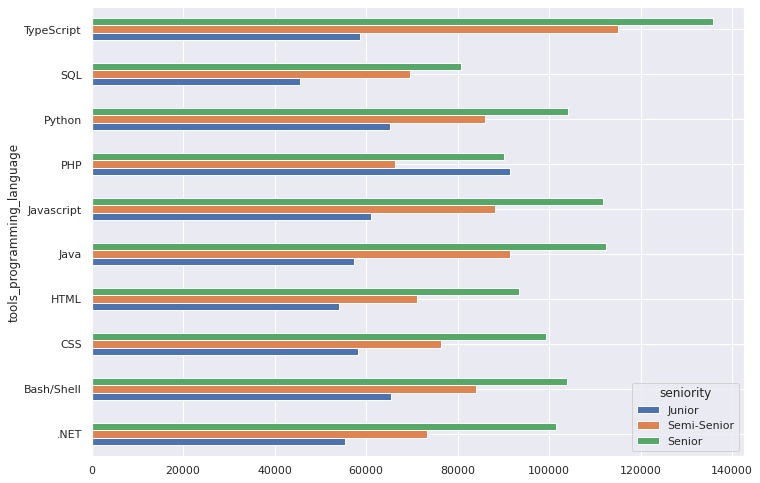

In [ ]:
# Removiendo outliers y eliminando valores menores a un SMVM ($24408 al dia de hoy)
iqr_factor = 3.5
df_copy_main_inliers, df_copy_main_outliers = remove_outlier(df_copy, "salary_monthly_NETO", iqr_factor)

df_copy_main_inliers = df_copy_main_inliers[df_copy_main_inliers["salary_monthly_NETO"] > 24408]

# Añadiendo columna 'senirority' para mejorar la visualizacion de la
# distribucion de la media de los salarios segun el lenguaje de programación
df_copy_main_inliers["seniority"] = pd.cut(
    df_copy_main_inliers["profile_years_experience"].values,
    [0, 2, 5, 50],
    labels=["Junior", "Semi-Senior", "Senior"],
)

# Otra propuesta para el análisis y visualización de la distribucion
# de la media de los salarios segun el lenguaje de programación
df_cured = (
    df_copy_main_inliers["tools_programming_languages"]
    .str.extractall(r"(?P<count>[^,]+),? ?")["count"]
    .value_counts(normalize=True, sort=True)
)
top_languages = df_cured[:10].index

chosen_languages = df_cured.to_frame().query("count > 0.01").index

df_cured = df_copy_main_inliers.copy()
df_cured = (
    df_cured["tools_programming_languages"]
    .str.split(",")
    .apply(pd.Series)
    .merge(df_cured, right_index=True, left_index=True)
    .drop(["tools_programming_languages"], axis=1)
    .melt(
        id_vars=["seniority", "salary_monthly_NETO"],
        value_name="tools_programming_language",
    )
    .drop(["variable"], axis=1)
    .dropna()
    .query("tools_programming_language in @top_languages")
    .groupby(["tools_programming_language", "seniority"])
    .mean()
    .unstack("seniority")["salary_monthly_NETO"]
    .fillna(0)
)

df_cured.loc[
    df_cured.eval("tools_programming_language not in @chosen_languages"),
    ["Junior", "Semi-Senior", "Senior"],
] *= -1

print(df_cured)
df_cured.plot(kind="barh")

# Conclusión
Los que tienene diferencia negativa ganan por debajo de la media.
Los que tienen una diferencia positva ganan por arriba de la media.
A partir del df que armamos con el filtrado de outliers y lenguajes con mas frecuencia determinamos que los lenguajes asociados a los mejores salarios son: python, bash/shell, java y typescript